In [62]:
import numpy as np
import matplotlib.pyplot as plt

# General Methods

In [64]:
""" Generate Data """

# generate train covariates 
def train_covariates(n, p, r): 
    U = np.random.normal(size=(n,r))
    V = np.random.normal(size=(p,r))
    X = U @ V.T
    return (X, U, V)                        

# generate observations
def add_noise(X, sigma=0.2):
    return X + np.random.normal(0, sigma, size=X.shape)

In [44]:
""" Compute k """

def donoho_rank(s, ratio): 
    """
    Retain all singular values above optimal threshold as per Donoho & Gavin '14:
    https://arxiv.org/pdf/1305.5870.pdf
    """ 
    omega = 0.56*ratio**3 - 0.95*ratio**2 + 1.43 + 1.82*ratio
    t = omega * np.median(s) 
    rank = max(len(s[s>t]), 1)
    return rank 

def spectral_rank(s, thresh=None):
    if thresh==1.0: 
        rank = len(s)
    else: 
        total_energy = (s**2).cumsum() / (s**2).sum()
        rank = list((total_energy>thresh)).index(True) + 1
    return rank

In [45]:
""" Algorithms """

# PCR
def pcr(Z, y, max_rank=None, thresh=None):
    # de-noise X
    (u, s, v) = np.linalg.svd(Z, full_matrices=False)
    if max_rank is not None: 
        rank = max_rank 
    if thresh is not None: 
        rank = _spectral_rank(s, thresh=thresh)
    else: 
        (m, n) = Z.shape 
        rank = donoho_rank(s, ratio=m/n)
    s_rank = s[:rank]
    u_rank = u[:, :rank]
    v_rank = v[:rank, :] 
    beta = ((v_rank.T/s_rank) @ u_rank.T) @ y
    return beta 

# HSVT
def hsvt(Z, max_rank=None, thresh=None):
    (u, s, v) = np.linalg.svd(Z, full_matrices=False)
    if max_rank is not None: 
        rank = max_rank 
    if thresh is not None: 
        rank = spectral_rank(s, thresh=thresh)
    else: 
        (m, n) = Z.shape 
        rank = donoho_rank(s, ratio=m/n)
    s_rank = s[:rank]
    u_rank = u[:, :rank]
    v_rank = v[:rank, :] 
    X_hat = (u_rank * s_rank) @ v_rank
    return (X_hat, rank)

In [46]:
""" Evaluation """

def param_est_error(beta, beta_hat): 
    return np.linalg.norm(beta_hat-beta)

def mse(y, y_hat): 
    return np.mean((y-y_hat)**2)

# SIMULATIONS

### Model Identification

In [96]:
# data
p = 512
r = 15
sample_sizes = np.linspace(30, p, 8)
sample_sizes = [int(n) for n in sample_sizes]

# noise
sigma = 0.2 

# simulation parameters
n_iters = 1000

# initialize
models = ['min norm model', 'random model']
errs_dict = {model: np.zeros(len(sample_sizes)) for model in models}

In [97]:
# generate regression model
beta = np.random.randn(p) 
beta /= np.linalg.norm(beta)

# iterate through sample sizes
for (idx, n) in enumerate(sample_sizes): 
    print("Sample size: {}...".format(n))
    
    # generate underlying data
    (X_train, _, _) = train_covariates(n, p, r)
    beta_min = np.linalg.pinv(X_train) @ X_train @ beta

    # iterate through different observation sets
    errs_temp = {model: np.zeros(n_iters) for model in models}
    
    for i in range(n_iters): 
        
        # corrupt data
        Z_train = add_noise(X_train, sigma=sigma)
        y_train = add_noise(X_train@beta, sigma=sigma)
        
        # PCR with oracle access 
        beta_hat = pcr(Z_train, y_train, max_rank=r)
        
        # evaluate
        errs_temp['random model'][i] = param_est_error(beta_hat, beta) 
        errs_temp['min norm model'][i] = param_est_error(beta_hat, beta_min)
        
    # record means
    for model in models: 
        errs_dict[model][idx] = np.median(errs_temp[model])
        
print("Done!")

Sample size: 30...
Sample size: 98...
Sample size: 167...
Sample size: 236...
Sample size: 305...
Sample size: 374...
Sample size: 443...
Sample size: 512...
Done!


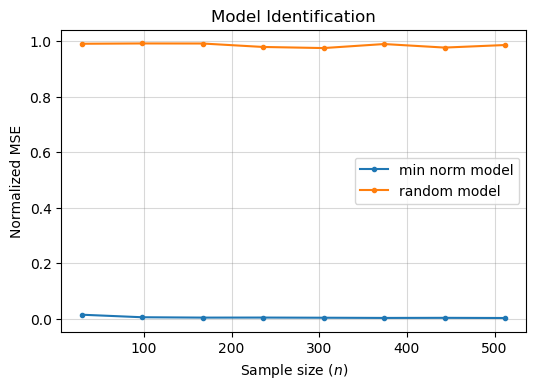

In [99]:
plt.figure(dpi=100)
for model in models:
    plt.plot(sample_sizes, errs_dict[model], marker='.', label=model)
plt.ylabel('Normalized MSE')
plt.xlabel('Sample size $(n)$')
plt.title('Model Identification')
plt.legend(loc='best')
plt.grid(color='grey', alpha=0.3)
#plt.yscale("log")
plt.show()

### Out-of-Sample Prediction: Covariate Shifts

In [100]:
# data
p = 512
r = 15
sample_sizes = np.linspace(30, p, 8)
sample_sizes = [int(n) for n in sample_sizes]

# noise
sigma = 0.2 

# simulation parameters
n_iters = 1000

# initialize
models = ['normal_1', 'uniform_1', 'normal_10', 'uniform_10']
errs_dict = {model: np.zeros(len(sample_sizes)) for model in models}

# generate test covariates that obeys subspace inclusion 
def test_covariates(m, r, V, generative_noise_type):    
    V_test = V[:, :r]
    if generative_noise_type == 'normal_1':
        U_test = np.random.normal(0, 1, size=(m,r))
    elif generative_noise_type == 'normal_10':
        U_test = np.random.normal(0, 5, size=(m,r))
    elif generative_noise_type == 'uniform_1':
        U_test = np.random.uniform(-np.sqrt(3), np.sqrt(3), size=(m,r))
    elif generative_noise_type == 'uniform_10':
        U_test = np.random.uniform(-np.sqrt(15), np.sqrt(15), size=(m,r))
    A_test = U_test @ V_test.T   
    return (A_test, U_test, V_test) 

In [101]:
# generate model parameter
beta = np.random.randn(p) 
beta /= np.linalg.norm(beta)

# iterate through sample sizes
for (idx, n) in enumerate(sample_sizes): 
    print("Sample size: {}...".format(n))
    
    # generate underlying data
    (X_train, U_train, V_train) = train_covariates(n, p, r)
    
    # iterate through noise models
    for model in models:
        print("Model: {}...".format(model))
        
        # generate underlying data
        (X_test, U_test, V_test) = test_covariates(n, r, V_train, model)
        y_test = X_test @ beta
        
        # initialize 
        errs_temp = np.zeros(n_iters)
        
        # iterate through different observation sets 
        for i in range(n_iters): 
            
            # corrupt data
            Z_train = add_noise(X_train, sigma=sigma)
            y_train = add_noise(X_train@beta, sigma=sigma)
            Z_test = add_noise(X_test, sigma=sigma)
            
            # PCR: model identification w/o oracle access 
            beta_hat = pcr(Z_train, y_train)
            
            # PCR: OOS prediction w/o oracle access
            (X_test_hat, _) = hsvt(Z_test)
            y_test_hat = X_test_hat @ beta_hat
            
            # record error
            errs_temp[i] = mse(y_test, y_test_hat)
            
        # record error
        errs_dict[model][idx] = np.median(errs_temp)
    print()
print("Done!")

Sample size: 30...
Model: normal_1...
Model: uniform_1...
Model: normal_10...
Model: uniform_10...

Sample size: 98...
Model: normal_1...
Model: uniform_1...
Model: normal_10...
Model: uniform_10...

Sample size: 167...
Model: normal_1...
Model: uniform_1...
Model: normal_10...
Model: uniform_10...

Sample size: 236...
Model: normal_1...
Model: uniform_1...
Model: normal_10...
Model: uniform_10...

Sample size: 305...
Model: normal_1...
Model: uniform_1...
Model: normal_10...
Model: uniform_10...

Sample size: 374...
Model: normal_1...
Model: uniform_1...
Model: normal_10...
Model: uniform_10...

Sample size: 443...
Model: normal_1...
Model: uniform_1...
Model: normal_10...
Model: uniform_10...

Sample size: 512...
Model: normal_1...
Model: uniform_1...
Model: normal_10...
Model: uniform_10...

Done!


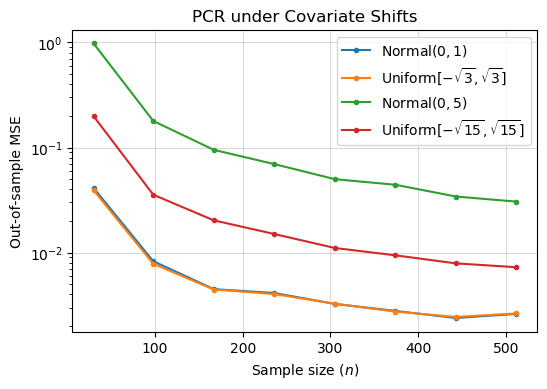

In [103]:
plt.figure(dpi=100)
plt.plot(sample_sizes, errs_dict['normal_1'], marker='.', label= 'Normal$(0, 1)$')
plt.plot(sample_sizes, errs_dict['uniform_1'], marker='.', label= 'Uniform$[-\sqrt{3}, \sqrt{3}]$')
plt.plot(sample_sizes, errs_dict['normal_10'], marker='.', label= 'Normal$(0, 5)$')
plt.plot(sample_sizes, errs_dict['uniform_10'], marker='.', label= 'Uniform$[-\sqrt{15}, \sqrt{15}]$')
plt.ylabel('Out-of-sample MSE')
plt.xlabel('Sample size $(n)$')
plt.title('PCR under Covariate Shifts')
plt.legend(loc='best')
plt.yscale("log")
plt.grid(color='grey', alpha=0.3)
plt.show()

### Out-of-Sample Predictions: Subspace Inclusion vs. Distributional Invariance

In [93]:
# data
p = 512
r = 15
sample_sizes = np.linspace(30, p, 8)
sample_sizes = [int(n) for n in sample_sizes]

# noise
sigma = 0.2 

# simulation parameters
n_iters = 1000

# initialize
models = ['subspace incl.', 'dist. invariance']
errs_dict = {model: np.zeros(len(sample_sizes)) for model in models}

In [94]:
# generate model parameter
beta = np.random.randn(p) 
beta /= np.linalg.norm(beta)

# iterate through sample sizes
for (idx, n) in enumerate(sample_sizes): 
    print("Sample size: {}...".format(n))
    
    # generate train data
    (X_train, U_train, V_train) = train_covariates(n, p, r)
        
    # generate test data: subspace inclusion
    U_test1 = np.random.normal(0, 5, size=(n,r))
    X_test1 = U_test1 @ V_train.T
    y_test1 = X_test1 @ beta
    
    # generate test data: dist. invariance
    V_test2 = np.random.normal(size=(p,r))
    X_test2 = U_train @ V_test2.T
    y_test2 = X_test2 @ beta
    
    # initialize
    errs_temp = {model: np.zeros(n_iters) for model in models}
    
    # iterate through different observation sets 
    for i in range(n_iters): 

        # corrupt data
        Z_train = add_noise(X_train, sigma=sigma)
        y_train = add_noise(X_train@beta, sigma=sigma) 
        Z_test1 = add_noise(X_test1, sigma=sigma)
        Z_test2 = add_noise(X_test2, sigma=sigma)

        # PCR: model identification w/o oracle access 
        beta_hat = pcr(Z_train, y_train)

        # PCR: OOS prediction w/o oracle access
        (X_test1_hat, _) = hsvt(Z_test1)
        y_test1_hat = X_test1_hat @ beta_hat
        errs_temp['subspace incl.'][i] = mse(y_test1, y_test1_hat)
        
        (X_test2_hat, _) = hsvt(Z_test2)
        y_test2_hat = X_test2_hat @ beta_hat
        errs_temp['dist. invariance'][i] = mse(y_test2, y_test2_hat)
  
    # record error
    errs_dict['subspace incl.'][idx] = np.median(errs_temp['subspace incl.'])
    errs_dict['dist. invariance'][idx] = np.median(errs_temp['dist. invariance'])
    
print("Done!")

Sample size: 30...
Sample size: 98...
Sample size: 167...
Sample size: 236...
Sample size: 305...
Sample size: 374...
Sample size: 443...
Sample size: 512...
Done!


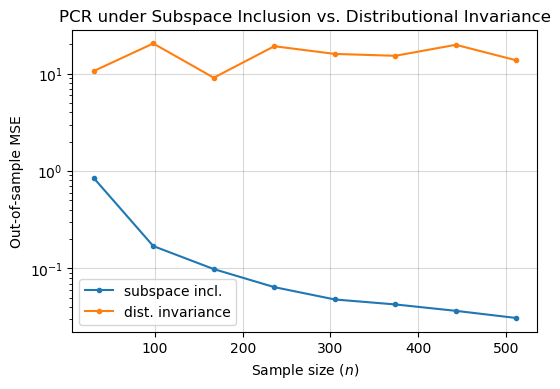

In [95]:
plt.figure(dpi=100)
for model in models:
    plt.plot(sample_sizes, errs_dict[model], marker='.', label=model)
plt.ylabel('Out-of-sample MSE')
plt.xlabel('Sample size $(n)$')
plt.title('PCR under Subspace Inclusion vs. Distributional Invariance')
plt.legend(loc='best')
plt.grid(color='grey', alpha=0.3)
plt.yscale("log")
plt.show()

# CASE STUDIES

In [10]:
import pandas as pd

In [24]:
# user input
data = 'Prop99'
alpha = 0.05

In [25]:
if data=='Basque':
    treated_unit = 'Basque'
elif data=='Prop99':
    treated_unit = 'California'
    
fname_pre = 'data/{}/pre_outcomes.csv'.format(data)
fname_post = 'data/{}/post_outcomes.csv'.format(data)
df_pre = pd.read_csv(fname_pre)
df_post = pd.read_csv(fname_post) 

In [26]:
# compute statistic 
def compute_tau_hat(X_train, X_test): 
    # train
    H_train = np.linalg.pinv(X_train) @ X_train
    H_train_perp = np.eye(X_train.shape[1]) - H_train
    
    # test
    H_test = np.linalg.pinv(X_test) @ X_test
    return np.linalg.norm(H_train_perp @ H_test, 'fro') ** 2

# get pre- and post-intervention covariates 
units = df_post.unit.unique() 
donors = units[units!=treated_unit]
pre_cols = list(df_pre.drop(columns=['unit']).columns)
post_cols = list(df_post.drop(columns=['unit']).columns) 
Z_pre = df_pre.loc[df_pre['unit'].isin(donors)].drop(columns=['unit']).values.T 
Z_post = df_post.loc[df_post['unit'].isin(donors)].drop(columns=['unit']).values.T 

# compute statistic 
(X_pre_hat, rank_pre) = hsvt(Z_pre)
(X_post_hat, rank_post) = hsvt(Z_post)
tau = alpha * rank_post
tau_hat = compute_tau_hat(X_pre_hat, X_post_hat)

# report
print("Rank of pre: {}".format(rank_pre))
print("Rank of post: {}".format(rank_post))
print("tau(alpha): {:.2f}".format(tau))
print("tau_hat: {:.2f}".format(tau_hat))

Rank of pre: 4
Rank of post: 3
tau(alpha): 0.15
tau_hat: 1.63
